In [5]:
%matplotlib notebook
import numpy as np
import collections
import os
import matplotlib.pyplot as plt
import amfe
from pyfeti import utils
from pyfeti.src.utils import OrderedSet, Get_dofs, save_object, dict2dfmap
from pyfeti import linalg

number_of_div = 3
creator_obj  = utils.DomainCreator(x_divisions=number_of_div,y_divisions=number_of_div)
creator_obj.build_elements()
mesh_path = r'meshes\mesh1.msh'
creator_obj.save_gmsh_file(mesh_path)

In [6]:
#import mesh
m = amfe.Mesh()
m.import_msh(mesh_path)

# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)

my_system = amfe.MechanicalSystem()
my_system.set_mesh_obj(m)
my_system.set_domain(3,my_material)

value = 5.0E9
my_system.apply_neumann_boundaries(2, value, 'normal')
id_matrix = my_system.assembly_class.id_matrix

K, f = my_system.assembly_class.assemble_k_and_f()
ndof = K.shape[0]
case_path = 'matrices\case_' + str(ndof)
try:
    os.mkdir(case_path)
except:
    pass


K0, fext = my_system.assembly_class.assemble_k_and_f_neumann()
save_object(K,os.path.join(case_path,'K.pkl'))
save_object(fext,os.path.join(case_path,'f.pkl'))

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 4 elements and 18 dofs.
Time taken for preallocation: 0.00 seconds.


In [7]:
id_map_df = dict2dfmap(id_matrix)
gdof = Get_dofs(id_map_df)

tag_dict = {}
tag_dict['left'] = 1
tag_dict['right'] = 2
tag_dict['bottom'] = 4
tag_dict['top'] = 5

get_nodes = lambda i : list(np.sort(m.groups[i].global_node_list))

all_dofs = set(gdof.get(get_nodes(3),'xy'))
#dof_dict = collections.OrderedDict()
dof_dict = {}
dofs = set()
for key, value in tag_dict.items():
    key_dofs = gdof.get(get_nodes(value),'xy')
    dof_dict[key] = key_dofs 
    dofs.update(key_dofs)

dof_dict['internal'] = list(all_dofs - dofs)   


In [9]:

s = utils.SelectionOperator(dof_dict,id_map_df,remove_duplicated = False)
save_object(s,os.path.join(case_path,'selectionOperator.pkl'))
B_list = []
for key, value in tag_dict.items():
    B = s.build_B(key)
    B_list.append(B)
    B_path = os.path.join(case_path,'B_' + key + '.pkl')
    save_object(B,B_path)

<IPython.core.display.Javascript object>


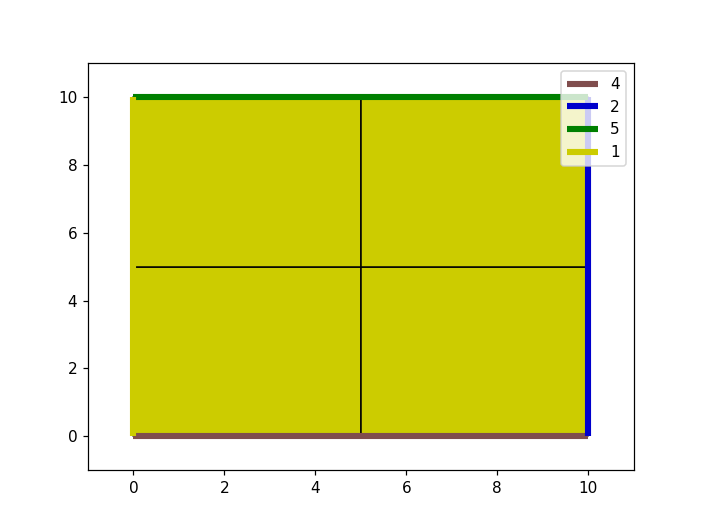

In [10]:
amfe.plot2Dmesh(m)
plt.savefig(os.path.join(case_path,'mesh.png'))